In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run params.py

In [3]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [4]:
analysis = scripts.Analysis()

In [5]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_CRD
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [6]:
iggs = [10]
markers = [None,]
color = 'r'
linestyle = '-'

df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wfluxg.dat'), 
                 sep=r'\s+')

df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wfluxg[df_wfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdx_igg = analysis.model('wgt_igg{}'.format(igg))
    crdx_igg.type_model = 'crd'
    crdx_igg.rundir = DIR_XCRD
    crdx_igg.fpath_flux = s_flux
    crdx_igg.fpath_coolr = s_coolr
    crdx_igg.color = color
    crdx_igg.marker = marker
    crdx_igg.linestyle = linestyle
    crdx_igg.load_data()

In [7]:
iggs = [10]
markers = ['D',]
color = 'g'
linestyle = ':'

df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 'output_wwfluxg.dat'), 
                 sep=r'\s+')

df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 'output_wwcoolrg.dat'), 
                 sep=r'\s+')

for igg, marker in zip(iggs, markers):

    flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg].drop('igg', axis=1)
    s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

    coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg].drop('igg', axis=1)
    s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))


    crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
    crdxx_igg.type_model = 'crd'
    crdxx_igg.rundir = DIR_XCRD
    crdxx_igg.fpath_flux = s_flux
    crdxx_igg.fpath_coolr = s_coolr
    crdxx_igg.color = color
    crdxx_igg.marker = marker
    crdxx_igg.linestyle = linestyle
    crdxx_igg.load_data()

In [8]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [9]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [10]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [11]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [12]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.005

klin =1e-24

nband = 80

ng =9

ng_refs = (/ 3 , 2 , 4 /) 

nref =3

nv = 200

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =257

vstar = 540

data w_diffuse
     &     /1.6 , 1.6 , 1.7 , 1.75,
     &     1.75 , 1.55 , 1.55 , 1.6,
     &     1.85/

data wgt
     &     /0.7 , 0.3 , 0.7 , 0.7,
     &     0.6 , 0.4 , 0.5 , 0.8,
     &     0.95/

atmosphere_profiles/saw75.pro


In [13]:
fig.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [17]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [18]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

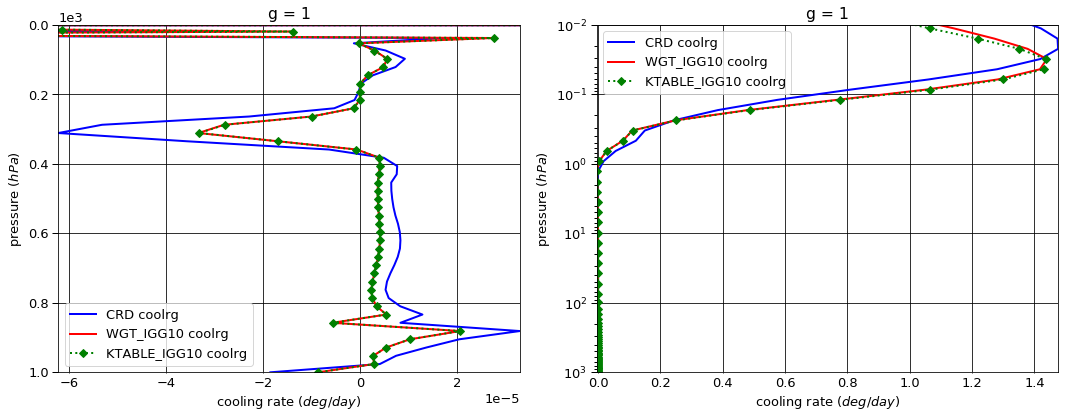

# Figure: cooling rate g-group 2

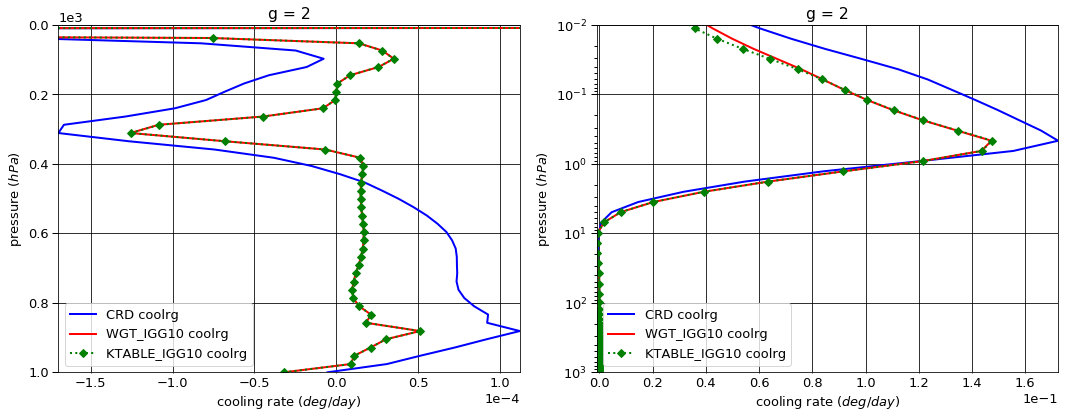

# Figure: cooling rate g-group 3

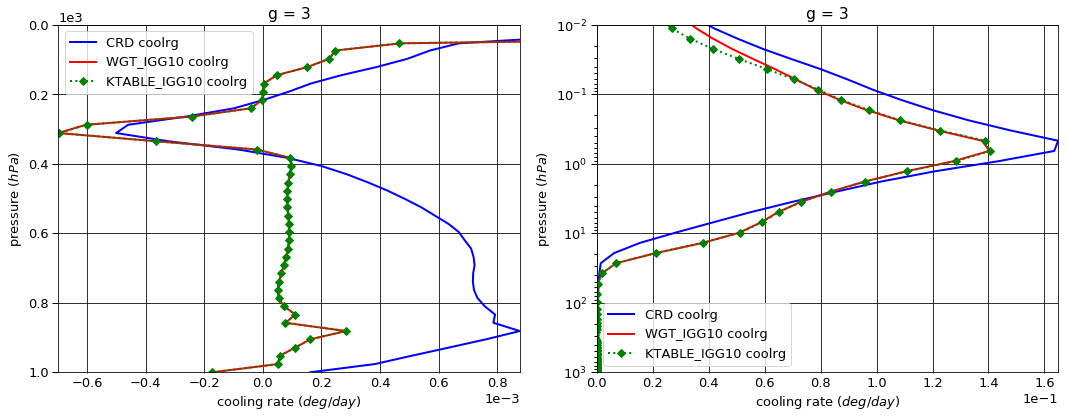

# Figure: cooling rate g-group 4

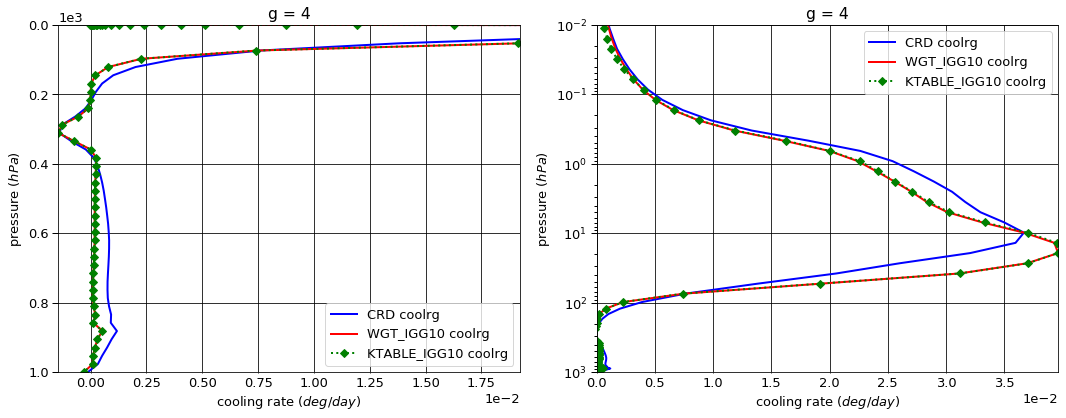

# Figure: cooling rate g-group 5

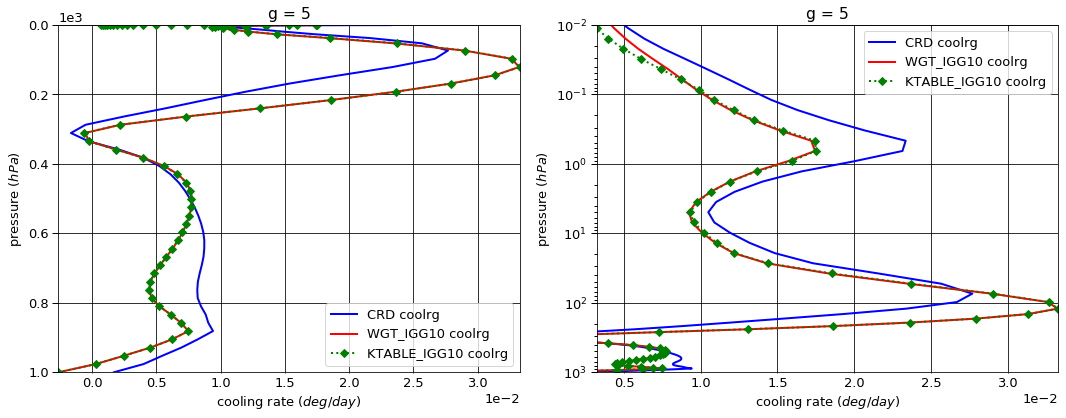

# Figure: cooling rate g-group 6

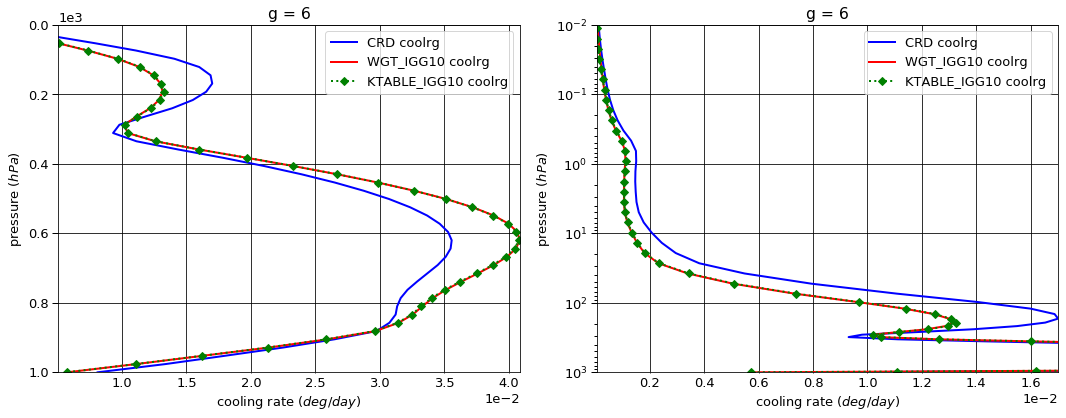

# Figure: cooling rate g-group 7

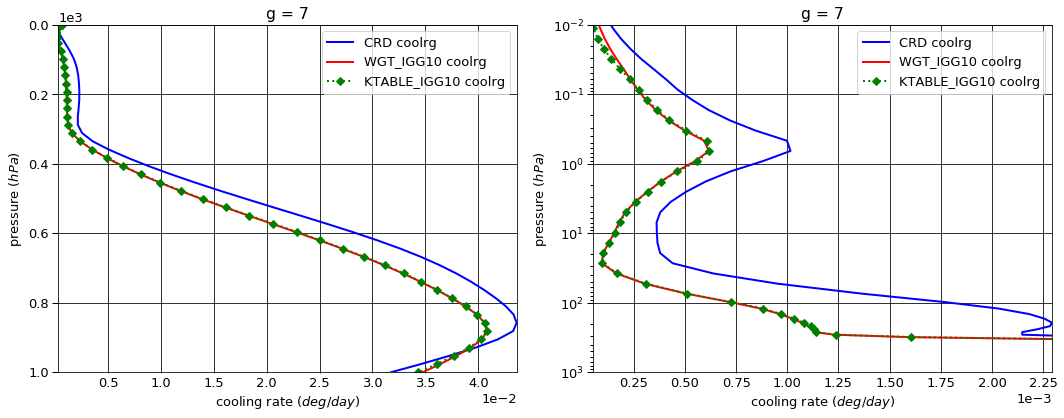

# Figure: cooling rate g-group 8

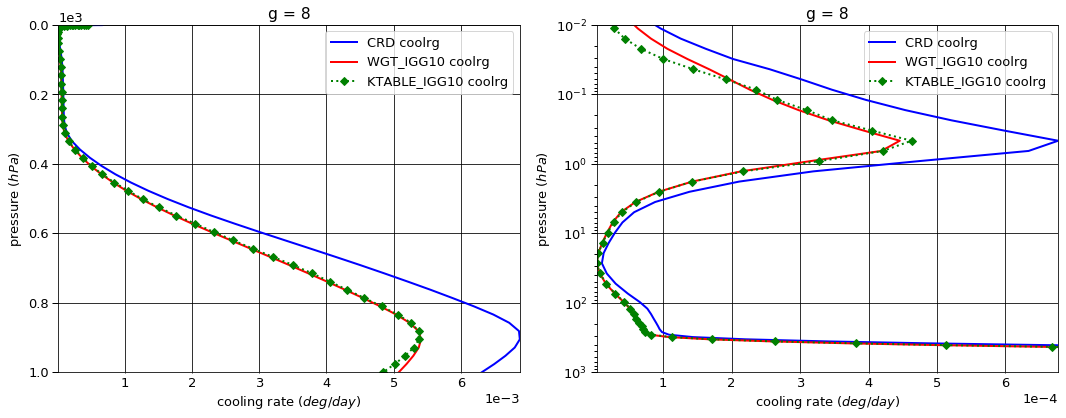

# Figure: cooling rate g-group 9

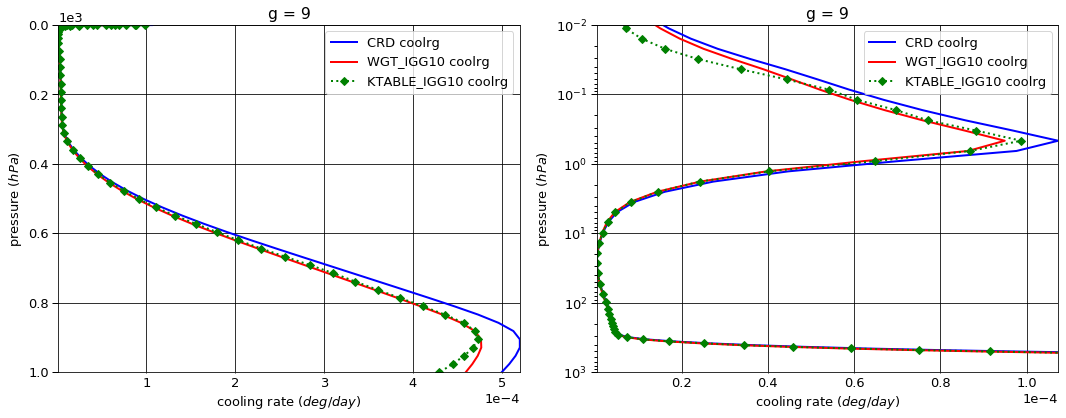

# Figure: cooling rate g-group total

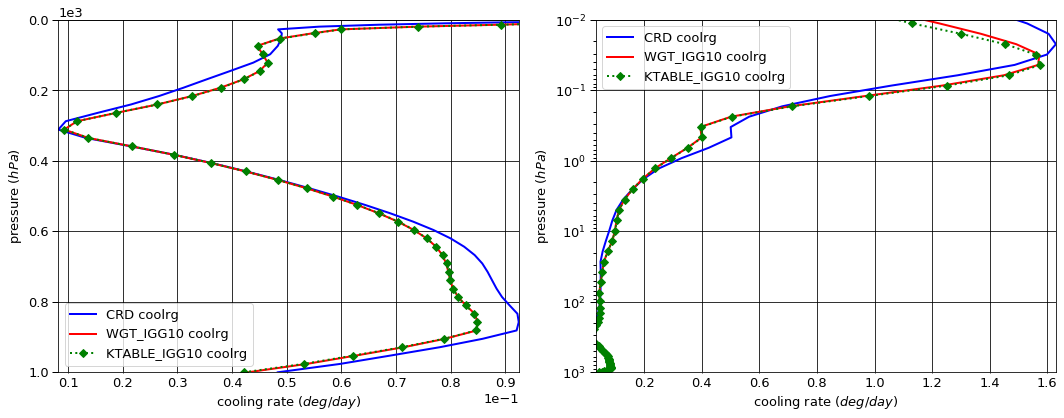

In [19]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025879  0.000000 -0.025879
  1013.0   76    -0.030250  0.030326  0.000076
2 0.0      1     -0.032607  0.000000 -0.032607
  1013.0   76    -0.041908  0.041463 -0.000445
3 0.0      1     -0.166636  0.000000 -0.166636
  1013.0   76    -0.256565  0.235420 -0.021145
4 0.0      1     -0.263543  0.000000 -0.263543
  1013.0   76    -0.495680  0.489131 -0.006549
5 0.0      1     -1.341452  0.000000 -1.341452
  1013.0   76    -2.092976  1.852579 -0.240397
6 0.0      1     -2.884873  0.000000 -2.884873
  1013.0   76    -4.055674  3.866200 -0.189474
7 0.0      1     -5.607608  0.000000 -5.607608
  1013.0   76    -6.069259  2.872765 -3.196495
8 0.0      1     -6.603631  0.000000 -6.603631
  1013.0   76    -6.638593  0.356781 -6.281812
9 0.0      1     -3.908443  0.000000 -3.908443
  1013.0   76    -3.910233  0.024562 -3.885671


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.025941  0.000000 -0.025941
  1013.0   76    -0.030250  0.030280  0.000030
2 0.0      1     -0.032095  0.000000 -0.032095
  1013.0   76    -0.041908  0.042024  0.000116
3 0.0      1     -0.145089  0.000000 -0.145089
  1013.0   76    -0.256565  0.257182  0.000617
4 0.0      1     -0.250114  0.000000 -0.250114
  1013.0   76    -0.495680  0.496787  0.001107
5 0.0      1     -1.134804  0.000000 -1.134804
  1013.0   76    -2.092976  2.116827  0.023851
6 0.0      1     -2.841527  0.000000 -2.841527
  1013.0   76    -4.055674  4.016120 -0.039554
7 0.0      1     -5.721891  0.000000 -5.721891
  1013.0   76    -6.069259  2.465666 -3.603593
8 0.0      1     -6.612120  0.000000 -6.612120
  1013.0   76    -6.638593  0.276310 -6.362283
9 0.0      1     -3.908588  0.000000 -3.908588
  1013.0   76    -3.910233  0.022517 -3.887716


KTABLE_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.026026  0.000000 -0.026026
  1013.0   76    -0.030250  0.030280  0.000030
2 0.0      1     -0.032103  0.000000 -0.032103
  1013.0   76    -0.041908  0.042024  0.000116
3 0.0      1     -0.145155  0.000000 -0.145155
  1013.0   76    -0.256565  0.257183  0.000618
4 0.0      1     -0.250132  0.000000 -0.250132
  1013.0   76    -0.495680  0.496791  0.001111
5 0.0      1     -1.134442  0.000000 -1.134442
  1013.0   76    -2.092976  2.116899  0.023923
6 0.0      1     -2.839107  0.000000 -2.839107
  1013.0   76    -4.055674  4.016329 -0.039345
7 0.0      1     -5.719285  0.000000 -5.719285
  1013.0   76    -6.069259  2.469613 -3.599646
8 0.0      1     -6.611514  0.000000 -6.611514
  1013.0   76    -6.638593  0.276960 -6.361634
9 0.0      1     -3.908536  0.000000 -3.908536
  1013.0   76    -3.910233  0.022543 -3.887690


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -6.128600e-05  0.000000 -0.000061
  1013.0   76     0.000000e+00 -0.000046 -0.000046
2 0.0      1      5.122680e-04  0.000000  0.000512
  1013.0   76     6.938894e-18  0.000561  0.000561
3 0.0      1      2.154702e-02  0.000000  0.021547
  1013.0   76     0.000000e+00  0.021762  0.021762
4 0.0      1      1.342908e-02  0.000000  0.013429
  1013.0   76     0.000000e+00  0.007657  0.007657
5 0.0      1      2.066476e-01  0.000000  0.206648
  1013.0   76    -4.440892e-16  0.264248  0.264248
6 0.0      1      4.334650e-02  0.000000  0.043346
  1013.0   76     0.000000e+00  0.149920  0.149920
7 0.0      1     -1.142830e-01  0.000000 -0.114283
  1013.0   76     0.000000e+00 -0.407098 -0.407098
8 0.0      1     -8.488300e-03  0.000000 -0.008488
  1013.0   76     0.000000e+00 -0.080471 -0.080471
9 0.0      1     -1.454000e-04  0.000000 -0.000145
  1013.0   76     4.440892e-16 -0.002045 -0.002045


KTABLE_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.465460e-04  0.000000 -0.000147
  1013.0   76     0.000000e+00 -0.000046 -0.000046
2 0.0      1      5.038960e-04  0.000000  0.000504
  1013.0   76     6.938894e-18  0.000561  0.000561
3 0.0      1      2.148126e-02  0.000000  0.021481
  1013.0   76     0.000000e+00  0.021763  0.021763
4 0.0      1      1.341151e-02  0.000000  0.013412
  1013.0   76     0.000000e+00  0.007660  0.007660
5 0.0      1      2.070103e-01  0.000000  0.207010
  1013.0   76    -4.440892e-16  0.264320  0.264320
6 0.0      1      4.576610e-02  0.000000  0.045766
  1013.0   76     0.000000e+00  0.150129  0.150129
7 0.0      1     -1.116767e-01  0.000000 -0.111677
  1013.0   76     0.000000e+00 -0.403151 -0.403151
8 0.0      1     -7.883100e-03  0.000000 -0.007883
  1013.0   76     0.000000e+00 -0.079821 -0.079821
9 0.0      1     -9.350000e-05  0.000000 -0.000094
  1013.0   76     4.440892e-16 -0.002019 -0.002019

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      3.432637e-01
  1001.112500 75    -1.848891e-05
2 0.000312    1      5.443912e-03
  1001.112500 75    -5.374715e-06
3 0.000312    1      7.092472e-03
  1001.112500 75     1.616117e-04
4 0.000312    1      1.721838e-04
  1001.112500 75    -1.307848e-04
5 0.000312    1      8.065899e-04
  1001.112500 75     1.689546e-03
6 0.000312    1      2.017233e-05
  1001.112500 75     8.108815e-03
7 0.000312    1      7.758179e-06
  1001.112500 75     3.174232e-02
8 0.000312    1      5.183919e-08
  1001.112500 75     6.306941e-03
9 0.000312    1      3.119117e-08
  1001.112500 75     4.999049e-04


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.219424e-01
  1001.112500 75    -8.653772e-06
2 0.000312    1      6.680584e-03
  1001.112500 75    -3.189506e-05
3 0.000312    1      8.197907e-03
  1001.112500 75    -1.722162e-04
4 0.000312    1      1.840714e-04
  1001.112500 75    -3.122167e-04
5 0.000312    1      1.045652e-03
  1001.112500 75    -2.628949e-03
6 0.000312    1      1.358857e-05
  1001.112500 75     5.754231e-03
7 0.000312    1      1.448603e-06
  1001.112500 75     3.475254e-02
8 0.000312    1     -4.173313e-07
  1001.112500 75     5.073421e-03
9 0.000312    1      2.390223e-08
  1001.112500 75     4.594652e-04


KTABLE_IGG10


coolrg
g pressure    layer              
1 0.000312    1      1.057009e-01
  1001.112500 75    -8.660369e-06
2 0.000312    1      4.966196e-03
  1001.112500 75    -3.190181e-05
3 0.000312    1      5.258778e-03
  1001.112500 75    -1.724060e-04
4 0.000312    1     -9.158448e-06
  1001.112500 75    -3.128005e-04
5 0.000312    1      6.909585e-04
  1001.112500 75    -2.622385e-03
6 0.000312    1      4.867534e-06
  1001.112500 75     5.715073e-03
7 0.000312    1      6.135445e-07
  1001.112500 75     3.433892e-02
8 0.000312    1     -6.985142e-08
  1001.112500 75     4.842023e-03
9 0.000312    1      4.665167e-09
  1001.112500 75     4.299696e-04


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.213212e-01
  1001.112500 75     9.835142e-06
2 0.000312    1      1.236672e-03
  1001.112500 75    -2.652035e-05
3 0.000312    1      1.105435e-03
  1001.112500 75    -3.338279e-04
4 0.000312    1      1.188764e-05
  1001.112500 75    -1.814319e-04
5 0.000312    1      2.390625e-04
  1001.112500 75    -4.318495e-03
6 0.000312    1     -6.583763e-06
  1001.112500 75    -2.354584e-03
7 0.000312    1     -6.309575e-06
  1001.112500 75     3.010221e-03
8 0.000312    1     -4.691705e-07
  1001.112500 75    -1.233520e-03
9 0.000312    1     -7.288948e-09
  1001.112500 75    -4.043971e-05


KTABLE_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.375628e-01
  1001.112500 75     9.828545e-06
2 0.000312    1     -4.777157e-04
  1001.112500 75    -2.652710e-05
3 0.000312    1     -1.833694e-03
  1001.112500 75    -3.340177e-04
4 0.000312    1     -1.813422e-04
  1001.112500 75    -1.820158e-04
5 0.000312    1     -1.156314e-04
  1001.112500 75    -4.311931e-03
6 0.000312    1     -1.530480e-05
  1001.112500 75    -2.393741e-03
7 0.000312    1     -7.144634e-06
  1001.112500 75     2.596603e-03
8 0.000312    1     -1.216906e-07
  1001.112500 75    -1.464918e-03
9 0.000312    1     -2.652601e-08
  1001.112500 75    -6.993524e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.834674,0.000000,-20.834674
1013.0,76,-23.591138,9.769225,-13.821912



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.672169,0.000000,-20.672169
1013.0,76,-23.591138,9.723712,-13.867426



KTABLE_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-20.666300,0.000000,-20.666300
1013.0,76,-23.591138,9.728621,-13.862516



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.625045e-01,0.000000,0.162504
1013.0,76,3.552714e-15,-0.045513,-0.045514



KTABLE_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,1.683732e-01,0.000000,0.168373
1013.0,76,3.552714e-15,-0.040604,-0.040604


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.356807
1001.112500,75,0.048354



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.138065
1001.112500,75,0.042886



KTABLE_IGG10


,,coolrg
pressure,layer,
0.000312,1,0.116613
1001.112500,75,0.042178



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.218742
1001.112500,75,-0.005469



KTABLE_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.240194
1001.112500,75,-0.006177


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001313,0.001276
2,0.001813,0.001769
3,0.011062,0.010838
4,0.021438,0.020926
5,0.090000,0.088449
6,0.174937,0.171284
7,0.258125,0.257021
8,0.278438,0.282004
9,0.162875,0.166433


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.758133e-19
2,1.296272e-20
3,9.557418e-22
4,6.761756e-22
5,5.021768e-23
6,1.772266e-22
7,1.332107e-23
8,1.001266e-24
9,1.011442e-25


In [23]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [24]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.758133e-19,NaN,0.001313,0.001276,0.001313,0.001276,1.0
2,1.296272e-20,0.073730,0.001813,0.001769,0.003125,0.003045,1.0
3,9.557418e-22,0.073730,0.011062,0.010838,0.014187,0.013883,1.0
4,6.761756e-22,0.707488,0.021438,0.020926,0.035625,0.034809,10.0
5,5.021768e-23,0.074267,0.090000,0.088449,0.125625,0.123258,10.0
6,1.772266e-22,3.529167,0.174937,0.171284,0.300562,0.294542,500.0
7,1.332107e-23,0.075164,0.258125,0.257021,0.558688,0.551563,500.0
8,1.001266e-24,0.075164,0.278438,0.282004,0.837125,0.833567,500.0
9,1.011442e-25,0.101016,0.162875,0.166433,1.000000,1.000000,500.0


In [25]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

# `absmean`-to-`absmeanlog` Ratio

In [26]:
absmean_absmeanlog = pd.read_csv(os.path.join(crd.rundir, 'absmean.dat'), 
                index_col=[0, 1, 2],
                sep=r'\s+')

taulyr = pd.read_csv(os.path.join(crd.rundir, 'output_taulyr.dat'),
                     index_col=[0, 1, 2],
                     sep=r'\s+')


pd.set_option('display.max_rows', None)
display.display( 
    pd.concat([absmean_absmeanlog, taulyr], axis=1)
    )
pd.reset_option('display.max_rows')



absmean    absmeanlog      ratio        taulyr
layer g pressure                                                        
1     1 0.000312     5.443514e-19  2.840123e-19   1.916647  2.468083e-03
      2 0.000312     9.654064e-21  7.337983e-21   1.315629  4.252150e-05
      3 0.000312     8.170352e-22  4.099170e-22   1.993172  3.678437e-06
      4 0.000312     7.058937e-24  6.275324e-24   1.124872  3.612192e-08
      5 0.000312     1.317541e-23  4.865858e-24   2.707726  5.214917e-08
      6 0.000312     1.269955e-25  1.237324e-25   1.026372  6.618841e-10
      7 0.000312     1.209705e-25  9.619496e-26   1.257555  5.747803e-10
      8 0.000312     6.659351e-26  2.046704e-26   3.253695  3.036774e-10
      9 0.000312     2.128603e-26  3.104363e-27   6.856809  1.078649e-10
2     1 0.000750     5.579296e-19  2.896769e-19   1.926041  1.018000e-03
      2 0.000750     1.000664e-20  7.564276e-21   1.322881  1.769035e-05
      3 0.000750     8.509357e-22  4.212046e-22   2.020243  1.539442e-06
      4 0.000750     7.475295e-24  6.638113e-24   1.126117  1.540290e-08
      5 0.000750     1.369815e-23  5.004394e-24   2.737224  2.179188e-08
      6 0.000750     1.334176e-25  1.299303e-25   1.026840  2.800041e-10
      7 0.000750     1.277679e-25  1.007724e-25   1.267886  2.436402e-10
      8 0.000750     7.135412e-26  2.122111e-26   3.362413  1.307590e-10
      9 0.000750     2.273654e-26  3.202911e-27   7.098712  4.639513e-11
3     1 0.001052     5.860851e-19  3.013488e-19   1.944873  1.497029e-03
      2 0.001052     1.075269e-20  8.030564e-21   1.338971  2.645390e-05
      3 0.001052     9.231662e-22  4.437618e-22   2.080319  2.330308e-06
      4 0.001052     8.306559e-24  7.348068e-24   1.130441  2.397754e-08
      5 0.001052     1.482055e-23  5.285808e-24   2.803839  3.291085e-08
      6 0.001052     1.470805e-25  1.430863e-25   1.027915  4.326176e-10
      7 0.001052     1.425909e-25  1.104847e-25   1.290594  3.783590e-10
      8 0.001052     8.200915e-26  2.280315e-26   3.596396  2.098082e-10
      9 0.001052     2.596980e-26  3.408431e-27   7.619283  7.427893e-11
4     1 0.001476     6.155497e-19  3.134919e-19   1.963526  2.201969e-03
      2 0.001476     1.156126e-20  8.520802e-21   1.356827  3.956899e-05
      3 0.001476     1.002385e-21  4.671777e-22   2.145619  3.531253e-06
      4 0.001476     9.263032e-24  8.160740e-24   1.135072  3.746911e-08
      5 0.001476     1.606241e-23  5.579324e-24   2.878916  4.978843e-08
      6 0.001476     1.627472e-25  1.581543e-25   1.029041  6.711271e-10
      7 0.001476     1.593942e-25  1.211344e-25   1.315846  5.883761e-10
      8 0.001476     9.440348e-26  2.450490e-26   3.852433  3.373590e-10
      9 0.001476     2.970495e-26  3.626823e-27   8.190349  1.191358e-10
5     1 0.002070     6.459712e-19  3.259570e-19   1.981768  3.235745e-03
      2 0.002070     1.242676e-20  9.028767e-21   1.376352  5.911864e-05
      3 0.002070     1.088216e-21  4.911907e-22   2.215465  5.348763e-06
      4 0.002070     1.035736e-23  9.085651e-24   1.139969  5.869317e-08
      5 0.002070     1.742137e-23  5.880616e-24   2.962508  7.533896e-08
      6 0.002070     1.805791e-25  1.752829e-25   1.030216  1.043746e-09
      7 0.002070     1.782293e-25  1.326567e-25   1.343538  9.145533e-10
      8 0.002070     1.086467e-25  2.630999e-26   4.129484  5.423397e-10
      9 0.002070     3.396849e-26  3.856319e-27   8.808527  1.909962e-10
6     1 0.002904     6.773435e-19  3.387382e-19   1.999608  4.751789e-03
      2 0.002904     1.335296e-20  9.554148e-21   1.397609  8.825636e-05
      3 0.002904     1.181201e-21  5.158573e-22   2.289781  8.101169e-06
      4 0.002904     1.161800e-23  1.014561e-23   1.145126  9.223835e-08
      5 0.002904     1.890999e-23  6.189101e-24   3.055369  1.140705e-07
      6 0.002904     2.009687e-25  1.948403e-25   1.031454  1.628257e-09
      7 0.002904     1.993577e-25  1.451119e-25   1.373820  1.421461e-09
      8 0.002904     1.250062e-25  2.822164e-26   4.429446  8.719285e-10
      9 0.0

# Histogram of wavenumbers in g-group 1

In [27]:
#pd.read_csv(os.path.join(crd.rundir, 'ig1.dat')).hist()

In [28]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
